# 1. Importing libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score,confusion_matrix
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv(r"C:\Users\Parth\Desktop\ML Projects\Spam Classification\SPAM text message 20170820 - Data.csv")

In [3]:
data.head()

Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

# Basic EDA and Data Cleaning

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
data.duplicated().sum()

415

In [6]:
data.drop_duplicates(keep='first',inplace=True)

In [7]:
data.shape

(5157, 2)

In [8]:
data.Category.value_counts()

ham     4516
spam     641
Name: Category, dtype: int64

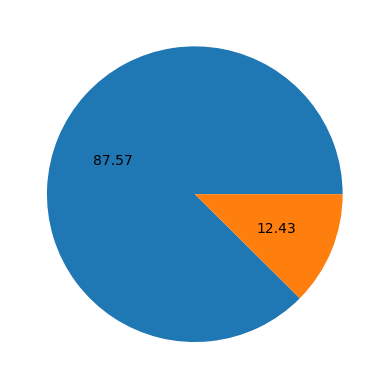

In [9]:
plt.pie(data['Category'].value_counts(),autopct='%.2f')
plt.show()

In [10]:
data['Category'].replace({'ham':0, 'spam':1},inplace=True)

# Downsampling Majority Class data to balance the dataset

In [11]:
ham_df=data[data['Category']==0]
spam_df=data[data['Category']==1]

In [12]:
print(ham_df.shape)
spam_df.shape

(4516, 2)


(641, 2)

In [13]:
ham_df_downsampled = ham_df.sample(spam_df.shape[0])
ham_df_downsampled.shape

(641, 2)

In [14]:
df_balanced=pd.concat([spam_df,ham_df_downsampled])
df_balanced.head()

Category                                            Message
2          1  Free entry in 2 a wkly comp to win FA Cup fina...
5          1  FreeMsg Hey there darling it's been 3 week's n...
8          1  WINNER!! As a valued network customer you have...
9          1  Had your mobile 11 months or more? U R entitle...
11         1  SIX chances to win CASH! From 100 to 20,000 po...

In [15]:
df_balanced.Category.value_counts()

1    641
0    641
Name: Category, dtype: int64

# Data Preprocessing and Feature Engineering

In [16]:
def preprocess(text):
    text=text.lower()
    tokens=nltk.word_tokenize(text)
    text=[]
    for token in tokens:
        if token not in stopwords.words('english') and token not in string.punctuation:
            text.append(token)
    
    return ' '.join(text)

In [17]:
df_balanced['text']=df_balanced['Message'].apply(preprocess)

In [18]:
df_balanced.head()

Category                                            Message  \
2          1  Free entry in 2 a wkly comp to win FA Cup fina...   
5          1  FreeMsg Hey there darling it's been 3 week's n...   
8          1  WINNER!! As a valued network customer you have...   
9          1  Had your mobile 11 months or more? U R entitle...   
11         1  SIX chances to win CASH! From 100 to 20,000 po...   

                                                 text  
2   free entry 2 wkly comp win fa cup final tkts 2...  
5   freemsg hey darling 's 3 week 's word back 'd ...  
8   winner valued network customer selected receiv...  
9   mobile 11 months u r entitled update latest co...  
11  six chances win cash 100 20,000 pounds txt csh...

In [19]:
wc=WordCloud(background_color='white',width=800,height=600)

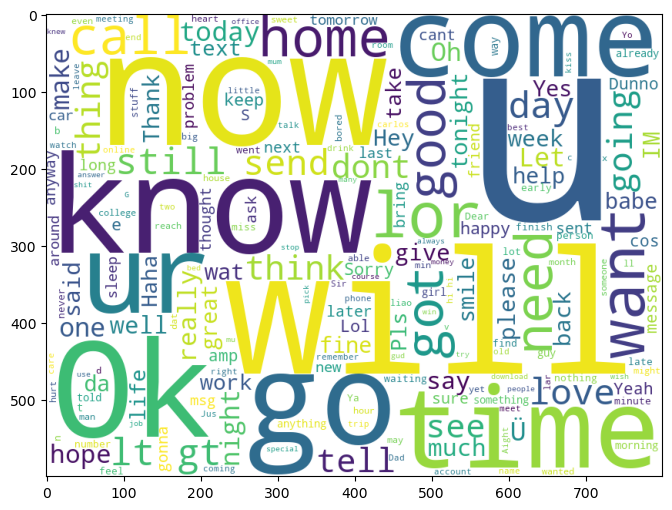

In [20]:
plt.figure(figsize=(10,6))
ham_wc=wc.generate(df_balanced[df_balanced['Category']==0]['Message'].str.cat(sep =' '))
plt.imshow(ham_wc)

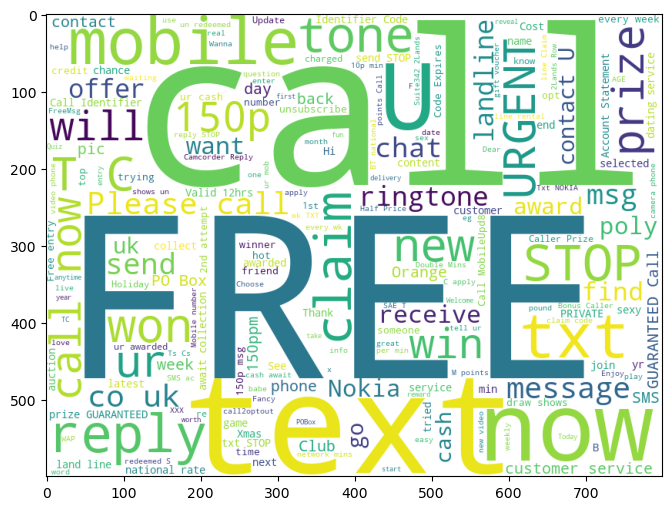

In [21]:
plt.figure(figsize=(10,6))
spam_wc=wc.generate(df_balanced[df_balanced['Category']==1]['Message'].str.cat(sep =' '))
plt.imshow(spam_wc)

# Text Vectorization and ML Model Building and Evaluation

In [22]:
X_train,X_test,y_train,y_test=train_test_split(df_balanced['text'], df_balanced['Category'],test_size=0.2)

In [23]:
tfidf=TfidfVectorizer()
X_train=tfidf.fit_transform(X_train).toarray()
X_test=tfidf.transform(X_test).toarray()

In [24]:
mnb=MultinomialNB(alpha=1.0)

In [25]:
mnb.fit(X_train,y_train)
mnb_pred=mnb.predict(X_test)
print('ROC AUC Score', roc_auc_score(mnb_pred, y_test))
print('F1 Score', f1_score(mnb_pred, y_test))
confusion_matrix(mnb_pred,y_test)

ROC AUC Score 0.933090467516697
F1 Score 0.9377289377289377


array([[112,  10],
       [  7, 128]], dtype=int64)

In [26]:
pickle.dump(tfidf,open('tfidf.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))